In [1]:
# version Fri 10:00

# Import Data Part

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import markers
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import sys
import random

marks = markers.MarkerStyle.markers.keys()
#print(marks)
random.seed(111)

None


In [57]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # cuts off tails from normal distribution, keeps elements [-2,2] #
    return tf.Variable(initial)

##### ----- Data Directories ---- #####
data_folder = "toy_dataset/"
save_folder = ["model_data/accuracy_data/","model_data/session_data/"]
dataset_file = ["configs.npy","labels.npy","labels64.npy"]
model_file = lambda i="": "toy_network_model_{}.ckpt".format(i)
#epoch_sess_file = lambda i: model_file.split('.')[0]+'_'+'{}'.format(i)+'.'+model_file.split('.')[0]


##### ----- Import data ---- #####
configs = np.load(data_folder+dataset_file[0])
num_configs = len(configs)
labels = np.empty([num_configs,2])
labels[:,0] = np.load(data_folder+dataset_file[1])

In [4]:
# convert labels into 1-hot representation
# y=0 --> (1,0)
# y=1 --> (0,1)
ind0 = (labels[:,0]==0)
ind1 = (labels[:,0]==1)
labels[ind0,:]=np.array([1,0])
labels[ind1,:]=np.array([0,1])
    
##### ----- Select training and test set ---- #####
# we choose the training set to be about 85% of the entire data set
num_train_configs = 3400
train_indices = random.sample(range(num_configs),num_train_configs)
test_indices = [ x for x in range(num_configs) if x not in train_indices]
    
configs_train = np.array( [configs[i] for i in train_indices] )
configs_test = np.array( [configs[i] for i in test_indices] )
labels_train = np.array( [labels[i] for i in train_indices] )
labels_test = np.array( [labels[i] for i in test_indices] )

# Training Model Part

In [58]:
##### ----- Create the model ---- #####
    
n_units = [12,10,7,5,4,3,2] # number of units in each layer, starting from the input layer
num_layers = len(n_units)

x = tf.placeholder(tf.float32, [None, n_units[0]])
W   = [None for i in range(num_layers-1)]
b   = [None for i in range(num_layers-1)]
out = [None for i in range(num_layers-1)]

for i in range(len(W)):
    W[i] = tf.Variable(tf.truncated_normal([n_units[i], n_units[i+1]], stddev=0.1))
    b[i] = tf.Variable(tf.truncated_normal([n_units[i+1]], stddev=0.1))

    if i==0: #first layer
        out[i] = tf.tanh( tf.matmul(x, W[i]) + b[i] )
    elif i<(len(W)-1):
        out[i] = tf.tanh( tf.matmul(out[i-1], W[i]) + b[i] )
    else: #output layer
        out[i] = tf.matmul(out[i-1], W[i])+b[i]
        y = out[i]

# define loss and optimizer
y_ = tf.placeholder(tf.float32,[None,2])

cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))  # Calculate the cross entropy (this tells us whether our network is actually learning)#
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# instructions on how to train our model
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1.6
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.96, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

# begin training sessions
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# define functions for testing of the trained model
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# add ops to save and restore all the variables
saver = tf.train.Saver()

# training parameters
minibatch_size = 20     # "batching" the configuration is what introduces stochasticity into the network (this is a must!)#
num_epochs = 1          # how many times do we run through the process and let our network learn



# define arrays to collect accuracy and error data during training
err_list  = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = []

# reshuffle the data set in each epoch
permut = np.arange(num_train_configs)

# Initialize Mutual Information
m = MUT_INFO(n_bins=1000, dataset_file=data_folder+dataset_file[2])
I = np.empty([num_layers-1,2,num_epochs])
    
for epoch in range(num_epochs):
    # save the variables to disk
    #save_path = saver.save(sess, "/Users/annagolubeva/Desktop/Information_Bottleneck/toy_network_model_{}.ckpt".format(epoch)
    #print("Model saved in file: %s" % save_path)
    np.random.shuffle(permut)
    train_configs = configs_train[permut,:]
    train_labels = labels_train[permut,:]
    for k in range(0, num_train_configs, minibatch_size):
        batch_xs = train_configs[k:k+minibatch_size,:]
        batch_ys = train_labels[k:k+minibatch_size,:]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        # for each epoch record one value of training accuracy and cross entropy
        if k==minibatch_size:
            train_acc[epoch] = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})   
            err_list[epoch] = sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys})
    # for every 10th epoch record the test accuracy
    if epoch%10==0:
        test_acc += [sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test})]
    
    # save the variables to disk each epoch
    save_path = saver.save(sess,data_folder+save_folder[1]+model_file(epoch+1))
    print("Model saved in file: %s" % data_folder+save_folder[1]+model_file(epoch+1)) 
        
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test Accuracy: ',sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test}))        
        
   
    
# save arrays with accuracy and error data
np.savez_compressed(data_folder+save_folder[0]+'{}epochs_train_acc'.format(num_epochs), a=train_acc)
np.savez_compressed(data_folder+save_folder[0]+'{}epochs_test_acc'.format(num_epochs), a=test_acc)
np.savez_compressed(data_folder+save_folder[0]+'{}epochs_err_list'.format(num_epochs), a=err_list)


Model saved in file: toy_dataset/model_data/session_data/toy_network_model_1.ckpt
Test Accuracy:  0.5301724


# Plot Information Plane

INFO:tensorflow:Restoring parameters from toy_dataset/model_data/session_data/toy_network_model_1.ckpt
Model restored.


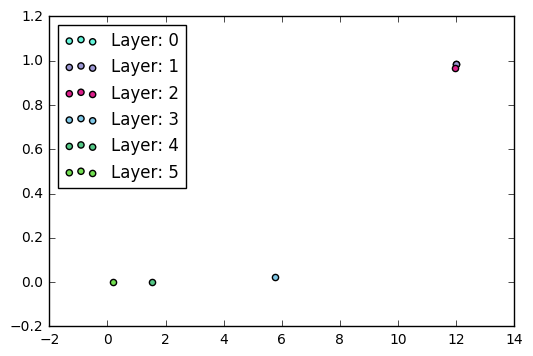

In [59]:
for epoch in range(num_epochs):
    # Import each epoch session file
    saver.restore(sess,data_folder+save_folder[1]+model_file(epoch+1))
    print("Model restored.")

    # Perform MI calculation [I(X,T), I(Y,T)] for each layer, once per epoch

    for i,layer_out in enumerate(out):
        I[i,:,epoch] = m.mut_info(layer_out.eval(feed_dict={x: configs}))
        plt.scatter(I[i,0,epoch],I[i,1,epoch],label='Layer: '+str(i),c=np.random.rand(3,1))
    plt.legend(loc=2,numpoints=1)
    plt.show()

In [52]:
epoch_sess_file = lambda i: model_file.split('.')[0]+'_'+'{}'.format(i)+'.'+model_file.split('.')[0]
epoch_sess_file(3)

'toy_network_model_3.toy_network_model'

# Mutual Information Part

In [6]:
# Calculate Mutual Information for Neural Network Input X, Output Y, Layers T

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#######  datafolder+ dataset_file[2] = /path_to/"labels64.npy"  ###############

class MUT_INFO(object):
    def __init__(self, n_bins=1000, dataset_file=data_folder+dataset_file[2]):
        
        # Initialize Mutual Information Class for given dataset
        # mut_info method will be called with layer output array:
        #     t = (Nx by n_t) array, where Nx is the number of datasets, and n_t is the number of neurons in the layer
        
        # Define bin size
        self.n_bins = n_bins
        
        # Calculate global p(x,y), p(x), |X|
        self.dataset_file = dataset_file
        self.prob_joint_X_binaryY()
        
        return
    
    
    def mut_info(self,t):
        # Estimate Mutual Information of between 
        # Random Variables (X,Y,T):   I(X,T) and I(Y,T)
        
        # Probability of p(t(x)) and delta(t(x),t(x'))
        p_tx,delta_tx = self.prob_t_x(t,n_bins=self.n_bins)      
        
        # Calculate Mutual Information of I(T,Y)
        # p_xy: (Ny(=2 for binary) by Nx) array,    p_tx = (Nx by 1) array,   
        # delta_tx = (Nx by Nx) array,  p_x = (Nx by 1) array
   
        I_TY = np.nansum(self.p_xy*
                         np.log2(np.dot(self.p_xy,delta_tx)/
                         np.sum(self.p_xy,1)[:,np.newaxis]/p_tx))
    
        I_TX = -np.dot(self.p_x,np.log2(p_tx))
        
        return [I_TX, I_TY]
    
        
    def prob_joint_X_binaryY(self):
    
        def py_x(u,gamma=30.5,theta=34):
            return 1.0/(1.0 + np.exp(-gamma*(u-theta)))

        # Import Original X Data and calculate size of 
        X = np.load(self.dataset_file).astype(np.float)
        
        # Define Probability Space NX
        self.NX = np.size(X)
        
        # Calculate p(x) and p(x,y)
        self.p_x = np.ones(self.NX)*1/self.NX
        
        self.p_xy = np.array([(1-py_x(X))*self.p_x,
                                  py_x(X)*self.p_x])
        
        return 
    

    def prob_t_x(self,t, n_bins): # Thanks Lauren!
        # Takes the layer's output t(x) and a number of bins
        # Returns a probability p(t(x)) 
        # as a vector and a matrix for KroneckerDelta(t(x), t(x'))

        # Define bins
        bins = np.linspace(-1, 1, n_bins)
        
        # Count number of appearance of each vector
        _, indices, counts= np.unique(np.digitize(t, bins), 
                                return_inverse=True, 
                                return_counts=True, axis=0)
        # Create delta matrix from indices
        delta = (np.array([indices,] * 
                          len(indices)).T == indices).astype(np.int)
        
        # Return p(t_x), delta
        return counts[indices]/self.NX, delta

# Plot Data Part

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the data
err_list = np.load('{}epochs_err_list.npz'.format(num_epochs))['a']
train_acc = np.load('{}epochs_train_acc.npz'.format(num_epochs))['a']
test_acc = np.load('{}epochs_test_acc.npz'.format(num_epochs))['a']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(np.arange(num_epochs), err_list, color='r')
plt.title('Cross Entropy')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0.3, 1.1])


plt.subplot(1,3,2)
plt.plot(np.arange(num_epochs), train_acc, color='b')
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.plot(np.arange(num_epochs/10), test_acc, color='g')
plt.title('Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch/10')
plt.ylim([0.3, 1.1])

print("minibatch size = %d" %minibatch_size)
print("number of epoches = %d" %num_epochs)
print("test accuracy final epoch = %f" %test_acc[-1])